# Unsupervised Clustering on MNIST using STAMPCluster

### Use GPU if available

In [80]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Install and Import CLIP Module

In [81]:
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q gdown
import clip
from torch import nn

## Prepare Train Val and Test Dataset

In [82]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image

# Define transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# Define the specific transformations for CLIP

clip_transform = transforms.Compose([
    transforms.Resize(256),                  # Resize the image to have a shorter side of 256 while maintaining aspect ratio
    transforms.CenterCrop(224),              # Crop the center to 224x224 size
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3 channels to match CLIP's input
    transforms.ToTensor(),                   # Convert the image to a PyTorch tensor
    transforms.Normalize(                    # Normalize using mean and std for 3-channel input
        mean=[0.48145466, 0.4578275, 0.40821073],  # CLIP's mean for RGB channels
        std=[0.26862954, 0.26130258, 0.27577711]   # CLIP's std for RGB channels
    ),
])


# Load CIFAR-10 dataset (train and test sets)
train_dataset = datasets.MNIST(root='/kaggle/working', train=True, download=True, transform=clip_transform)
test_dataset = datasets.MNIST(root='/kaggle/working', train=False, download=True, transform=clip_transform)

# Split train dataset into train and validation sets for unsupervised learning
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 256

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Clustering Accuracy Calculation using Hungarian Algorithm

In [83]:
from scipy.optimize import linear_sum_assignment
import numpy as np
import torch

import numpy as np
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(y_true, y_pred):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Ensure labels are within [0, D-1] range
    y_true = y_true - np.min(y_true)
    y_pred = y_pred - np.min(y_pred)

    # Find number of classes (D)
    D = max(y_pred.max(), y_true.max()) + 1

    # Build the contingency matrix (confusion matrix)
    contingency_matrix = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        contingency_matrix[y_pred[i], y_true[i]] += 1

    # Use Hungarian algorithm (linear sum assignment) to find the best match
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

    # Calculate clustering accuracy
    accuracy = contingency_matrix[row_ind, col_ind].sum() / y_pred.size
    
    # Create a new array to store the final mapped labels
    mapped_labels = np.full_like(y_pred, -1)  # Initialize with -1 (unmapped labels)

    # Assign the mapped labels
    for i in range(len(row_ind)):
        mapped_labels[y_pred == row_ind[i]] = col_ind[i]
    
    return accuracy * 100, mapped_labels  # Return accuracy and the final mapped labels

## Load learned Subjects from preprocessed Dataset

In [84]:
import os
import json
from collections import Counter

# Path to the JSON file
subjects_path = '/kaggle/input/mnist-processed/subjects.json'

# Check if the JSON file exists
if os.path.exists(subjects_path):
    # Load subjects from the JSON file
    with open(subjects_path, 'r') as file:
        subjects = json.load(file)
    print("subjects loaded from subjects.json:", Counter(subjects))


subjects loaded from subjects.json: Counter({'outlier': 41242, '7': 3070, '3': 1014, '5': 948, '2': 820, '8': 363, '9': 223, '4': 205, '6': 86, '1': 13, '4x4': 10, '0': 3, '24': 1, '3d': 1, 'x8': 1})


## Filter Outlier/Noisy Subjects

In [85]:
from collections import Counter

# Count the occurrences of each subject
subject_counts = Counter(subjects)

# Filter subjects whose count is at least 50
new_subjects = [subject for subject, count in subject_counts.items()]

# print(new_subjects)

unique_subjects = list(set(new_subjects))
print(unique_subjects)

['9', '8', '7', '4', 'x8', '0', '4x4', 'outlier', '6', '2', '24', '5', '3', '3d', '1']


## Initialize CLIP Module and text and image feature extraction functions

In [86]:
clip_model, clip_preprocess = clip.load('ViT-B/32', device)
templates = cifar10_templates = [
    'a photo of {}'
]

@torch.no_grad()
def extract_text_features(text_subjects, model):
    class_names = text_subjects
    model.to(device)
    model.eval()

    zeroshot_weights = []
    for classname in class_names:
        texts = [template.format(classname) for template in templates]
        texts = clip.tokenize(texts).to(device)
        class_embeddings = model.encode_text(texts)
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights

In [87]:
def extract_image_features(dataloader):
    # Extract image features and make predictions
    image_features = []
    image_labels = []
    # batch_num = 0
    for image, class_id in dataloader:
        # print(batch_num, end = ' ')
        # batch_num+=1
        image= image.to(device)
        # image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            image_feature = clip_model.encode_image(image)
        image_feature /= image_feature.norm()
        image_features.append(image_feature)
        image_labels.append(class_id)
    image_features = torch.cat(image_features, dim=0).to(device)  # Stack along batch dimension
    image_labels = torch.cat(image_labels).to(device)  # Flatten all label tensors
    return image_features, image_labels

## Define and Load STAMPCluster module

In [88]:
import torch
import torch.nn as nn
import clip

class STAMPCluster(nn.Module):
    def __init__(self, subjects, clip_model, device):
        super(STAMPCluster, self).__init__()
        self.subjects = subjects
        self.clip_model = clip_model
        self.device = device
        self.text_features = extract_text_features(subjects, clip_model)
        
    def forward(self, dataloader):
        image_features, image_labels = extract_image_features(dataloader)
        text_features = self.text_features
        logits = (100. * image_features @ text_features).softmax(dim=-1)
        _, predicted_classes = logits.topk(1, dim=-1)
        predicted_classes = predicted_classes.squeeze().cpu().numpy()
        predictions = predicted_classes
        return predictions, image_labels


In [89]:
model = STAMPCluster(unique_subjects, clip_model, device)

### Accuracy on Train split

In [90]:
predictions, image_labels = model(train_loader)

acc_score, mapped_labels = clustering_accuracy(image_labels, predictions)

print("Train ACC score:", acc_score)

Train ACC score: 35.483333333333334


### Accuracy on Val split

In [91]:
predictions, image_labels = model(val_loader)

acc_score, mapped_labels = clustering_accuracy(image_labels, predictions)

print("Val ACC score:", acc_score)

Val ACC score: 34.725


### Accuracy on Test split

In [92]:
predictions, image_labels = model(test_loader)

acc_score, mapped_labels = clustering_accuracy(image_labels, predictions)

print("Test ACC score:", acc_score)

Test ACC score: 36.720000000000006


## NMI Score on Test split


In [93]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(image_labels.cpu().numpy(), predictions)
print(f"Normalized Mutual Information (NMI): {100*nmi}")

Normalized Mutual Information (NMI): 28.621046328527605


## ARI Score on Test split

In [94]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(image_labels.cpu().numpy(), predictions)
print(f"Adjusted Rand Index (ARI): {100*ari}")

Adjusted Rand Index (ARI): 17.98021379866694


## t-SNE Plots

In [95]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
def plot_tsne(features, predictions, num_classes, title="t-SNE Visualization"):
    if isinstance(features, torch.Tensor):
        features = features.cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_features = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_features[:, 0], reduced_features[:, 1],
        c=predictions, cmap=plt.cm.get_cmap("tab10", num_classes),
        alpha=0.7, edgecolor='k', s=15
    )
    plt.colorbar(scatter, ticks=range(num_classes))
    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()


In [96]:
import os
import torch

processed_data_path = '/kaggle/input/mnist-processed/test_data.pt'

if os.path.exists(processed_data_path):
    checkpoint = torch.load(processed_data_path)
    test_features = checkpoint['test_features']
    test_labels = checkpoint['test_labels']
    print("Loaded test_features and test_labels from test_data.pt.")

Loaded test_features and test_labels from test_data.pt.


/tmp/ipykernel_30/2594294806.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(processed_data_path)


### t-SNE on actual test labels

/tmp/ipykernel_30/2874319743.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c=predictions, cmap=plt.cm.get_cmap("tab10", num_classes),


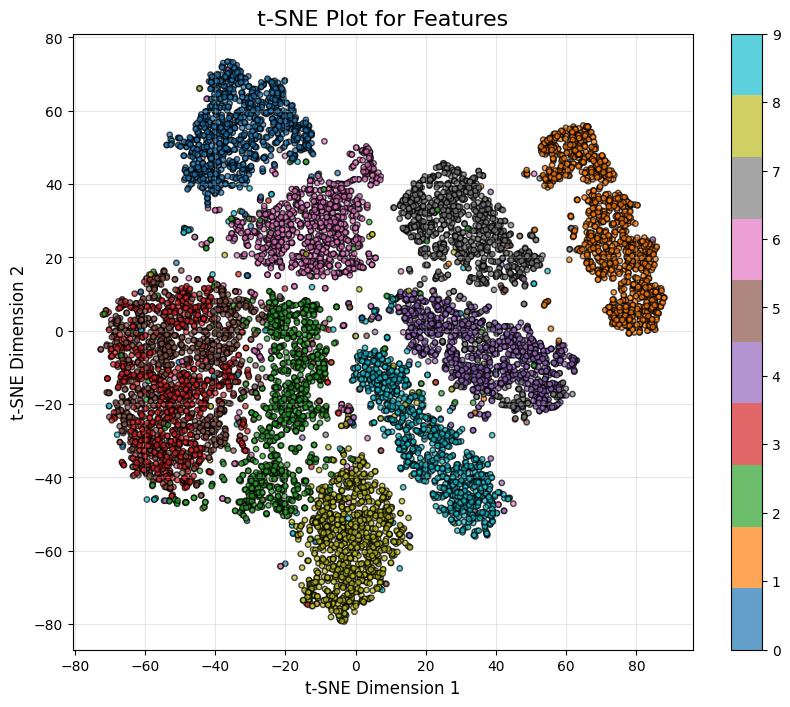

In [97]:
num_classes = len(np.unique(test_labels))  # Get the number of unique classes
plot_tsne(test_features, test_labels, num_classes, title="t-SNE Plot for Features")

### t-SNE on predicted test labels

/tmp/ipykernel_30/2874319743.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c=predictions, cmap=plt.cm.get_cmap("tab10", num_classes),


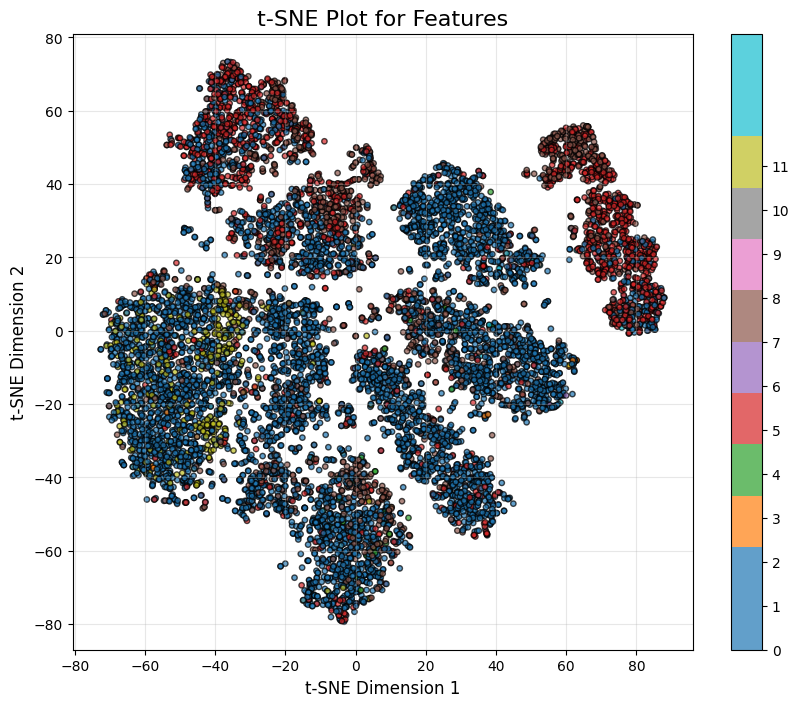

In [98]:
num_classes = len(np.unique(predictions))  # Get the number of unique classes
plot_tsne(test_features, predictions, num_classes, title="t-SNE Plot for Features")